In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [30]:
def windowing(image, pixels = [0, 1024], window = [50, 200]):
  #init window
  intfilt = sitk.IntensityWindowingImageFilter()
  #pixel intensities
  intfilt.SetOutputMinimum(pixels[0])
  intfilt.SetOutputMaximum(pixels[1])
  #the actual windowing
  intfilt.SetWindowMinimum(window[0])
  intfilt.SetWindowMaximum(window[1])
  #return
  return intfilt.Execute(image)

# 1.5 T

353it [03:27,  1.70it/s]


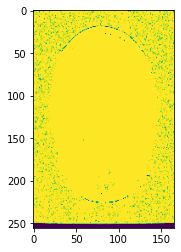

In [31]:
# # Declare the parent data folder and take one image from that folder
directory = r'/content/gdrive/MyDrive/AD_NET/AD-Net/sai_stuff/EDA/images/EDA-Trial2/50_1.5_and_3T/50_1.5T'
out_path = "/content/gdrive/MyDrive/AD_NET/AD-Net/sai_stuff/EDA/images/EDA-Trial2/windowed_images_trial2/window_1_5_T"

for root, subdirectories, files in tqdm(os.walk(directory)):
    for file in files:
        if file == '.DS_Store':
          continue
        img_path = os.path.join(root, file)
        #print(img_path)
        
        # Read the image in and print its size and display one slice
        img = sitk.ReadImage(img_path)
        np_img = sitk.GetArrayFromImage(img)
        # print(np_img.shape)
        # print(img.GetSize())
        plt.imshow(np_img[120,:,:])                                             # Sagittal[:,120,:] Cornalview[:,:,120] Transverse [120,:,:]
        
        # Apply windowing to the image and print its size and display one slice
        new_img = windowing(img)
        np_img2 = sitk.GetArrayFromImage(new_img)
        # print(new_img.GetSize())
        plt.imshow(np_img2[120,:,:])                                            # Cornalview[:,120,:] SagitalView[:,:,120] Transverse [120,:,:]

        # Write the image out to display in ITK-SNAP
        os.makedirs(out_path, exist_ok=True) # you can put a path into this command and it will create the directory
        sitk.WriteImage(new_img, os.path.join(out_path, "test_img_wind_"+img_path.split('/')[-1]))


# Downsampling 1.5 T

353it [11:21,  1.93s/it]


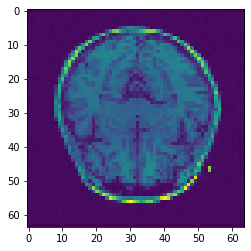

In [32]:
# # Declare the parent data folder and take one image from that folder
directory = r'/content/gdrive/MyDrive/AD_NET/AD-Net/sai_stuff/EDA/images/EDA-Trial2/50_1.5_and_3T/50_1.5T'
out_path = "/content/gdrive/MyDrive/AD_NET/AD-Net/sai_stuff/EDA/images/EDA-Trial2/low_res_trail2/low_res_1_5_T"# need to remove this .This is added again here just for testing.

for root, subdirectories, files in tqdm(os.walk(directory)):
    for file in files:
        if file == '.DS_Store':
          continue
        img_path = os.path.join(root, file)
        # print(img_path)

        # Read the image in and print its size and display one slice
        img = sitk.ReadImage(img_path)
        np_img = sitk.GetArrayFromImage(img)
        # print(np_img.shape)
        # print(img.GetSize())
        plt.imshow(np_img[120,:,:])                                              # Cornalview[:,120,:] SagitalView[:,:,120] Transverse [120,:,:]


        hi_res_images_path = os.path.join(directory) # TODO: no purpose
        write_image_path = os.path.join(directory)
        os.makedirs(write_image_path, exist_ok=True)

# Original Image:
        # Image before resampling
        img = sitk.ReadImage(img_path)
      
        # # print the size and spacing of the image
        # print(img.GetSize())
        # print(img.GetSpacing())

        # convert the image to a numpy array and plot a slice
        hi_res_array = sitk.GetArrayFromImage(img)
        a = np.float32(hi_res_array)
        plt.imshow(hi_res_array[120,:,:]) # can only show one slice at a time, so can only have one number in one axis (other two must be colons)   # Sagittal[:,120,:] Coronal[:,:,120] Transverse [120,:,:]

# Resampling:
        # Resample the image to a common 1x1x1 mm spacing
        img.SetOrigin([0, 0, 0])
        original_spacing = img.GetSpacing()
        original_size = img.GetSize()
        out_spacing = (1,1,1)
        out_size = [
                int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
                int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
                int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2]))),
            ]
        resample = sitk.ResampleImageFilter()
        resample.SetOutputSpacing(out_spacing)
        resample.SetSize(out_size)
        resample.SetOutputDirection(img.GetDirection())
        resample.SetOutputOrigin(img.GetOrigin())
        resample.SetTransform(sitk.Transform())
        resample.SetDefaultPixelValue(img.GetPixelIDValue())
        resample.SetInterpolator(sitk.sitkBSpline)
        resample_img = resample.Execute(img) 


        # Write the image out
        os.makedirs(out_path, exist_ok=True)
        # print('*'*5)
        # print(out_path)
   
        sitk.WriteImage(resample_img,  os.path.join(out_path,"resample", img_path.split('/')[-1]))
        # print('*'*5)

      # Read the resampled image back in and plot it
        A = sitk.ReadImage(os.path.join(out_path,"resample", img_path.split('/')[-1]))
        # print(A.GetSize()) # should be the same as above
        # print(A.GetSpacing()) # should be the same as above
        B = sitk.GetArrayFromImage(A)
        plt.imshow(B[120,:,:])                                                   # Sagittal[:,120,:] Coronal[:,:,120] Transverse [120,:,:]

# Reshaping:
        # Reshape the image
        resample_img.SetOrigin([0,0,0])
        out_size = (64,64,64)

        original_spacing = resample_img.GetSpacing()
        original_size = resample_img.GetSize()

        out_spacing = [
            (original_size[0] * (original_spacing[0] / out_size[0])),
            (original_size[1] * (original_spacing[1] / out_size[1])),
            (original_size[2] * (original_spacing[2] / out_size[2])),
        ]

        reference_image = sitk.Image(out_size, 1)
        reference_image.SetDirection(resample_img.GetDirection())
        reference_image.SetSpacing(out_spacing)
        reference_image.SetPixel
        interpolator = sitk.sitkBSpline
        reshape_img = sitk.Resample(resample_img, reference_image, sitk.Transform(), interpolator) # the reshaped image

        # display the size and spacing of the respaced image
        # print(reshape_img.GetSize())
        # print(reshape_img.GetSpacing())

        # Write the reshaped image out
        os.makedirs(out_path, exist_ok=True)
        sitk.WriteImage(reshape_img, os.path.join(out_path,"reshape", img_path.split('/')[-1]))

        # Read the reshaped image back in and plot it
        E = sitk.ReadImage(os.path.join(out_path,"reshape", img_path.split('/')[-1]))
        # print(E.GetSize())
        # print(E.GetSpacing()) 
        F = sitk.GetArrayFromImage(E)
        plt.imshow(F[32,:,:])                                                   # Sagittal[:,32,:] Coronal[:,:,32] Transverse [32,:,:]


# Image Matrix Function Common for all

reshaped images must be used for image matrix. Else Dimensional errors occur. 

In [33]:
# making n X m matrix
def img2np(img_path_list, size = (64, 64)):
  
    # iterating through each file
    full_mat = None 
    for f_path in tqdm(img_path_list):
        
        # Read the image and print its size and display one slice algong with converting it into Numpy
        img = sitk.ReadImage(f_path)
        img_np = sitk.GetArrayFromImage(img)#converting into Numpy #shape of the img_np is (64,64,64)
        print(img_np.shape)
        # print(img.GetSize())

        plt.imshow(img_np[63,:,:])    
                                                   # Cornalview[:,63,:] SagitalView[:,:,63]
        # turn that into a vector / 1D array
        # print(img_np.reshape(-1, 64).shape) # Changing ravel to reshape

        img_np = np.array([img_np]) #shape of the img_np is (38,64,64,64)
        if full_mat is not None:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_np), axis=0)
        else: 
            # if not assigned yet, assign one
            full_mat = img_np
    # print('=====', full_mat.shape)
    return full_mat

# 1.5T Image Matrix 

In [34]:
t_1_5_imgs =  [] 
for root, subdirectories, files in tqdm(os.walk(os.path.join(out_path,"reshape"))):# reshaped image path must be used
  for f_name in files:
    if f_name.endswith('.nii'):
      t_1_5_imgs.append(os.path.join(root,f_name))  

1it [00:00, 117.69it/s]


  2%|▏         | 2/108 [00:00<00:10,  9.98it/s]

(64, 64, 64)
(64, 64, 64)


  6%|▌         | 6/108 [00:00<00:06, 15.58it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


  8%|▊         | 9/108 [00:00<00:05, 17.75it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 12%|█▏        | 13/108 [00:00<00:05, 18.02it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 16%|█▌        | 17/108 [00:00<00:04, 18.38it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 19%|█▉        | 21/108 [00:01<00:04, 17.98it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 23%|██▎       | 25/108 [00:01<00:04, 17.46it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 27%|██▋       | 29/108 [00:01<00:04, 17.56it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 31%|███       | 33/108 [00:01<00:04, 16.60it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 34%|███▍      | 37/108 [00:02<00:04, 16.56it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 38%|███▊      | 41/108 [00:02<00:04, 16.26it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 42%|████▏     | 45/108 [00:02<00:03, 16.36it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 45%|████▌     | 49/108 [00:02<00:03, 15.31it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 47%|████▋     | 51/108 [00:03<00:03, 14.34it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 51%|█████     | 55/108 [00:03<00:03, 14.61it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 53%|█████▎    | 57/108 [00:03<00:03, 14.82it/s]

(64, 64, 64)
(64, 64, 64)


 56%|█████▋    | 61/108 [00:03<00:03, 12.56it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 58%|█████▊    | 63/108 [00:04<00:03, 13.06it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 62%|██████▏   | 67/108 [00:04<00:03, 13.19it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 64%|██████▍   | 69/108 [00:04<00:03, 12.83it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 68%|██████▊   | 73/108 [00:04<00:02, 12.98it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 69%|██████▉   | 75/108 [00:04<00:02, 12.67it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 73%|███████▎  | 79/108 [00:05<00:02, 12.85it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 75%|███████▌  | 81/108 [00:05<00:02, 12.91it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 79%|███████▊  | 85/108 [00:05<00:01, 12.80it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 81%|████████  | 87/108 [00:05<00:01, 12.73it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 84%|████████▍ | 91/108 [00:06<00:01, 12.76it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 86%|████████▌ | 93/108 [00:06<00:01, 12.61it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 90%|████████▉ | 97/108 [00:06<00:00, 12.35it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 92%|█████████▏| 99/108 [00:06<00:00, 12.27it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 94%|█████████▎| 101/108 [00:07<00:00, 12.16it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 97%|█████████▋| 105/108 [00:07<00:00, 12.34it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


100%|██████████| 108/108 [00:07<00:00, 14.02it/s]

(64, 64, 64)
(64, 64, 64)


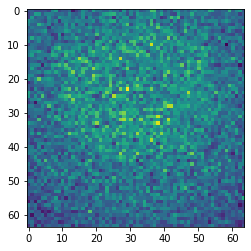

In [35]:
# run it on our folders
image_matrix_1_5_T = img2np(t_1_5_imgs)
# print(image_matrix_1_5_T.shape)

# 1.5 T - Average Image

In [36]:
def find_mean_img(full_mat, title):
  # Image dimensions have changed. Reshape image along 3rd dimension.
    
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    print(mean_img.shape)
    # reshape it back to a matrix
    
    plt.imshow(mean_img[:, 32, :], vmin=0, vmax=255, cmap='Greys_r')             # Cornalview[32, :, :] SagitalView[:,:,32]
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

(64, 64, 64)


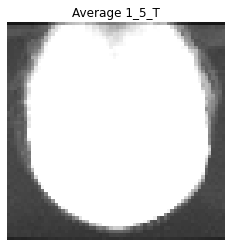

In [37]:
image_matrix_1_5_T.shape
mean_1_5_T = find_mean_img(image_matrix_1_5_T,'1_5_T')

# 3 T

353it [00:32, 10.87it/s]


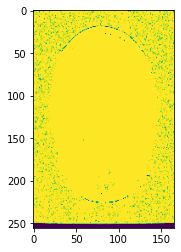

In [38]:
# # Declare the parent data folder and take one image from that folder
directory_3T = r'/content/gdrive/MyDrive/AD_NET/AD-Net/sai_stuff/EDA/images/EDA-Trial2/50_1.5_and_3T/50_3_T'
out_path = "/content/gdrive/MyDrive/AD_NET/AD-Net/sai_stuff/EDA/images/EDA-Trial2/windowed_images_trial2/window_3_T"

for root, subdirectories, files in tqdm(os.walk(directory)):
    for file in files:
        if file == '.DS_Store':
          continue
        img_path = os.path.join(root, file)
        #print(img_path)
        
        # Read the image in and print its size and display one slice
        img = sitk.ReadImage(img_path)
        np_img = sitk.GetArrayFromImage(img)
        # print(np_img.shape)
        # print(img.GetSize())
        plt.imshow(np_img[120,:,:])                                             # Sagittal[:,120,:] Coronal[:,:,120]
        
        # Apply windowing to the image and print its size and display one slice
        new_img = windowing(img)
        np_img2 = sitk.GetArrayFromImage(new_img)
        # print(new_img.GetSize())
        plt.imshow(np_img2[120,:,:])                                            # Sagittal[:,120,:] Coronal[:,:,120]

        # Write the image out to display in ITK-SNAP
        os.makedirs(out_path, exist_ok=True) # you can put a path into this command and it will create the directory
        sitk.WriteImage(new_img, os.path.join(out_path, "test_img_wind_"+img_path.split('/')[-1]))

# Downsampling 3 T

345it [16:24,  2.85s/it]


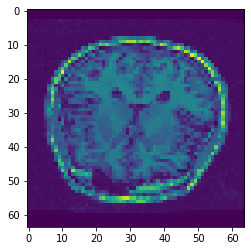

In [39]:
# # Declare the parent data folder and take one image from that folder
directory = r'/content/gdrive/MyDrive/AD_NET/AD-Net/sai_stuff/EDA/images/EDA-Trial2/50_1.5_and_3T/50_3_T'
out_path = "/content/gdrive/MyDrive/AD_NET/AD-Net/sai_stuff/EDA/images/EDA-Trial2/low_res_trail2/low_res_3_T"# need to remove this .This is added again here just for testing.

for root, subdirectories, files in tqdm(os.walk(directory)):
    for file in files:
        if file == '.DS_Store':
          continue
        img_path = os.path.join(root, file)
        # print(img_path)

        # Read the image in and print its size and display one slice
        img = sitk.ReadImage(img_path)
        np_img = sitk.GetArrayFromImage(img)
        # print(np_img.shape)
        # print(img.GetSize())
        plt.imshow(np_img[32,:,:])                                              # Cornalview[:,32,:] SagitalView[:,:,32]


        hi_res_images_path = os.path.join(directory) # TODO: no purpose
        write_image_path = os.path.join(directory)
        os.makedirs(write_image_path, exist_ok=True)

# Original Image:
        # Image before resampling
        img = sitk.ReadImage(img_path)
      
        # # print the size and spacing of the image
        # print(img.GetSize())
        # print(img.GetSpacing())

        # convert the image to a numpy array and plot a slice
        hi_res_array = sitk.GetArrayFromImage(img)
        a = np.float32(hi_res_array)
        plt.imshow(hi_res_array[32,:,:]) # can only show one slice at a time, so can only have one number in one axis (other two must be colons)          # Cornalview[:,32,:] SagitalView[:,:,32]

# Resampling:
        # Resample the image to a common 1x1x1 mm spacing
        img.SetOrigin([0, 0, 0])
        original_spacing = img.GetSpacing()
        original_size = img.GetSize()
        out_spacing = (1,1,1)
        out_size = [
                int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
                int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
                int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2]))),
            ]
        resample = sitk.ResampleImageFilter()
        resample.SetOutputSpacing(out_spacing)
        resample.SetSize(out_size)
        resample.SetOutputDirection(img.GetDirection())
        resample.SetOutputOrigin(img.GetOrigin())
        resample.SetTransform(sitk.Transform())
        resample.SetDefaultPixelValue(img.GetPixelIDValue())
        resample.SetInterpolator(sitk.sitkBSpline)
        resample_img = resample.Execute(img) # the respaced image

        # # display the size and spacing of the respaced image
        # print(resample_img.GetSize())
        # print(resample_img.GetSpacing())

        # Write the image out
        os.makedirs(out_path, exist_ok=True)
        # print('*'*5)
        # print(out_path)
        # print(img_path.split('/')[-1], os.path.join(out_path,"resample", img_path.split('/')[-1]))
        sitk.WriteImage(resample_img,  os.path.join(out_path,"resample", img_path.split('/')[-1]))
        # print('*'*5)

      # Read the resampled image back in and plot it
        A = sitk.ReadImage(os.path.join(out_path,"resample", img_path.split('/')[-1]))
        # print(A.GetSize()) # should be the same as above
        # print(A.GetSpacing()) # should be the same as above
        B = sitk.GetArrayFromImage(A)
        plt.imshow(B[32,:,:])                                                     # Cornalview[:,32,:] SagitalView[:,:,32]

# Reshaping:
        # Reshape the image
        resample_img.SetOrigin([0,0,0])
        out_size = (64,64,64)

        original_spacing = resample_img.GetSpacing()
        original_size = resample_img.GetSize()

        out_spacing = [
            (original_size[0] * (original_spacing[0] / out_size[0])),
            (original_size[1] * (original_spacing[1] / out_size[1])),
            (original_size[2] * (original_spacing[2] / out_size[2])),
        ]

        reference_image = sitk.Image(out_size, 1)
        reference_image.SetDirection(resample_img.GetDirection())
        reference_image.SetSpacing(out_spacing)
        reference_image.SetPixel
        interpolator = sitk.sitkBSpline
        reshape_img = sitk.Resample(resample_img, reference_image, sitk.Transform(), interpolator) # the reshaped image

        # display the size and spacing of the respaced image
        # print(reshape_img.GetSize())
        # print(reshape_img.GetSpacing())

        # Write the reshaped image out
        os.makedirs(out_path, exist_ok=True)
        sitk.WriteImage(reshape_img, os.path.join(out_path,"reshape", img_path.split('/')[-1]))

        # Read the reshaped image back in and plot it
        E = sitk.ReadImage(os.path.join(out_path,"reshape", img_path.split('/')[-1]))
        # print(E.GetSize())
        # print(E.GetSpacing()) 
        F = sitk.GetArrayFromImage(E)
        plt.imshow(F[32,:,:])                                                     # Cornalview[:,32,:] SagitalView[:,:,32]


# 3 T Image Matrix

In [40]:
t_3_imgs =  [] 
for root, subdirectories, files in os.walk(os.path.join(out_path,"reshape")):# reshaped image path must be used
  for f_name in files:
    if f_name.endswith('.nii'):
      t_3_imgs.append(os.path.join(root,f_name))  

  1%|          | 1/105 [00:00<00:21,  4.84it/s]

(64, 64, 64)


  4%|▍         | 4/105 [00:00<00:11,  8.77it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


  8%|▊         | 8/105 [00:00<00:08, 12.06it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 11%|█▏        | 12/105 [00:01<00:06, 15.16it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 15%|█▌        | 16/105 [00:01<00:05, 16.17it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 19%|█▉        | 20/105 [00:01<00:05, 16.47it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 23%|██▎       | 24/105 [00:01<00:05, 16.08it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 27%|██▋       | 28/105 [00:01<00:04, 16.60it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 30%|███       | 32/105 [00:02<00:04, 16.74it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 34%|███▍      | 36/105 [00:02<00:04, 17.03it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 38%|███▊      | 40/105 [00:02<00:03, 17.10it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 40%|████      | 42/105 [00:02<00:03, 16.55it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 44%|████▍     | 46/105 [00:03<00:03, 15.70it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)

 48%|████▊     | 50/105 [00:03<00:03, 14.95it/s]


(64, 64, 64)
(64, 64, 64)


 50%|████▉     | 52/105 [00:03<00:03, 14.72it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 53%|█████▎    | 56/105 [00:03<00:03, 14.65it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 57%|█████▋    | 60/105 [00:04<00:03, 13.77it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 59%|█████▉    | 62/105 [00:04<00:03, 13.33it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 63%|██████▎   | 66/105 [00:04<00:03, 12.80it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 65%|██████▍   | 68/105 [00:04<00:02, 12.74it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 69%|██████▊   | 72/105 [00:05<00:02, 12.38it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 70%|███████   | 74/105 [00:05<00:02, 12.23it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 72%|███████▏  | 76/105 [00:05<00:02, 12.24it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 76%|███████▌  | 80/105 [00:05<00:02, 12.04it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 80%|████████  | 84/105 [00:06<00:01, 12.14it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 82%|████████▏ | 86/105 [00:06<00:01, 11.66it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 84%|████████▍ | 88/105 [00:06<00:01, 11.94it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 88%|████████▊ | 92/105 [00:06<00:01, 11.69it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 90%|████████▉ | 94/105 [00:06<00:00, 11.95it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 93%|█████████▎| 98/105 [00:07<00:00, 11.56it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 95%|█████████▌| 100/105 [00:07<00:00, 11.52it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


 99%|█████████▉| 104/105 [00:07<00:00, 11.23it/s]

(64, 64, 64)
(64, 64, 64)
(64, 64, 64)


100%|██████████| 105/105 [00:07<00:00, 13.33it/s]


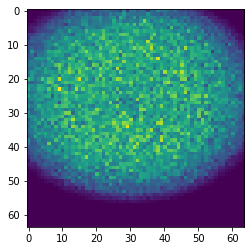

In [41]:
# run it on our folders
image_matrix_3_T = img2np(t_3_imgs)
# print(image_matrix_3_T.shape)

# 3 T Average Image

In [54]:
def find_mean_img(full_mat, title):
  # Image dimensions have changed. Reshape image along 3rd dimension.  
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    print(mean_img.shape)
    # reshape it back to a matrix
    
    plt.imshow(mean_img[:, 32, :], vmin=0, vmax=255, cmap='Greys_r')                # Sagital[32,:,:] coronal [:,:,32] transverse [:,32,:]
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

(64, 64, 64)


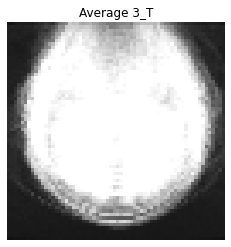

(64, 64, 64)


In [55]:
image_matrix_3_T.shape
mean_3_T = find_mean_img(image_matrix_3_T,'3_T')
print(mean_3_T.shape)

# Contrast Between mean 1.5 T and 3 T images

(64, 64, 64)


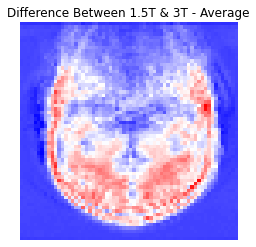

In [44]:
contrast_mean = mean_1_5_T - mean_3_T
print(contrast_mean.shape)
plt.imshow(contrast_mean[:, 32, :], cmap='bwr')                                # Cornalview[32,:,:] SagitalView[:,:,32]
plt.title(f'Difference Between 1.5T & 3T - Average')
plt.axis('off')
plt.show()

# Eigen Images

In [45]:
# image_matrix_1_5_T.shape
image_matrix_3_T.shape

(105, 64, 64, 64)

Number of PC:  6
Number of PC:  6
Number of PC:  7
Number of PC:  7
Number of PC:  7
Number of PC:  7
Number of PC:  10
Number of PC:  10
Number of PC:  8
Number of PC:  7
Number of PC:  8
Number of PC:  8
Number of PC:  8
Number of PC:  8
Number of PC:  7
Number of PC:  7
Number of PC:  7
Number of PC:  16
Number of PC:  7
Number of PC:  7
Number of PC:  9
Number of PC:  6
Number of PC:  9
Number of PC:  6
Number of PC:  9
Number of PC:  9
Number of PC:  8
Number of PC:  8
Number of PC:  9
Number of PC:  9
Number of PC:  9
Number of PC:  10
Number of PC:  10
Number of PC:  8
Number of PC:  8
Number of PC:  9
Number of PC:  9
Number of PC:  8
Number of PC:  8
Number of PC:  8
Number of PC:  8
Number of PC:  9
Number of PC:  9
Number of PC:  9
Number of PC:  9
Number of PC:  9
Number of PC:  9
Number of PC:  8
Number of PC:  8
Number of PC:  7
Number of PC:  7
Number of PC:  8
Number of PC:  8
Number of PC:  7
Number of PC:  8
Number of PC:  5
Number of PC:  5
Number of PC:  7
Number of

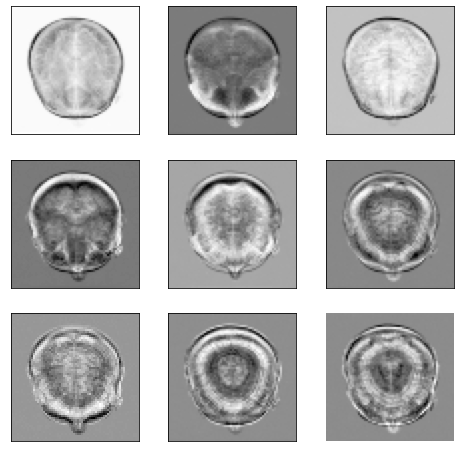

In [46]:
from sklearn.decomposition import PCA
from math import ceil

def get_eigenimage(input_mat, n_comp = 0.7):
  """
  This method returns the eigenimage for input set if images
  Args:
    input_mat : A tensor of shape (n_samples, img_len, img_width)
    n_comp: 
  Returns:
    eigenimage for the input
  """
  # fit PCA to describe n_comp * variability in the class
  pca = PCA(n_components = n_comp, whiten = True)
  input_mat = input_mat.reshape(input_mat.shape[0], -1)
  pca.fit(input_mat)
  print('Number of PC: ', pca.n_components_)
  return pca


def plot_pca(pca, size = (64, 64)):
  """
  Plot all the principal components obtained from PCA run
  """
  # plot eigenimages in a grid
  # plot all pca of given input
  n = pca.n_components_ 
  fig = plt.figure(figsize=(8, 8))
  r = int(n**.5)
  c = ceil(n/ r)
  for i in range(n):
      ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
      ax.imshow(pca.components_[i].reshape(size), 
                cmap='Greys_r')
  plt.axis('off')
  plt.show()

eigen_image_list_1_5_T = []
for pos in range(image_matrix_1_5_T.shape[0]):
  pca_input = image_matrix_1_5_T[pos] # pca_input is the slice which i want to get eigenimage for
  eigen_image_list_1_5_T.append(get_eigenimage(pca_input))
  
print("1.5T")
plot_pca(get_eigenimage(pca_input))


Number of PC:  8
Number of PC:  8
Number of PC:  7
Number of PC:  7
Number of PC:  11
Number of PC:  11
Number of PC:  10
Number of PC:  10
Number of PC:  7
Number of PC:  8
Number of PC:  8
Number of PC:  8
Number of PC:  10
Number of PC:  8
Number of PC:  10
Number of PC:  1
Number of PC:  9
Number of PC:  7
Number of PC:  8
Number of PC:  9
Number of PC:  9
Number of PC:  7
Number of PC:  7
Number of PC:  10
Number of PC:  9
Number of PC:  9
Number of PC:  9
Number of PC:  9
Number of PC:  9
Number of PC:  9
Number of PC:  9
Number of PC:  11
Number of PC:  11
Number of PC:  10
Number of PC:  10
Number of PC:  10
Number of PC:  10
Number of PC:  8
Number of PC:  7
Number of PC:  8
Number of PC:  8
Number of PC:  9
Number of PC:  8
Number of PC:  8
Number of PC:  8
Number of PC:  8
Number of PC:  11
Number of PC:  11
Number of PC:  7
Number of PC:  7
Number of PC:  8
Number of PC:  8
Number of PC:  6
Number of PC:  8
Number of PC:  8
Number of PC:  7
Number of PC:  7
Number of PC:  7

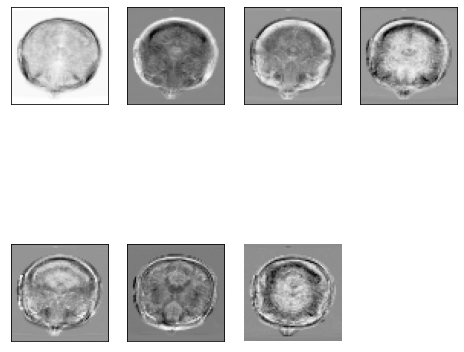

In [47]:
eigen_image_list_3_T = []
for pos in range(image_matrix_3_T.shape[0]):
  pca_input = image_matrix_3_T[pos] 
  eigen_image_list_3_T.append(get_eigenimage(pca_input))

print("3T")
plot_pca(get_eigenimage(pca_input)) # 